In [5]:
import numpy as np
import pandas as pd
import edit_distance
from sklearn import linear_model, preprocessing
from sklearn.linear_model import HuberRegressor, Ridge
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import matplotlib as mpl

In [66]:
# Time to load in the data
data2 = pd.read_csv("../cr7_no_ceiling.csv")
energies2 = pd.read_csv("../subopt_attributes7.csv")
energies2["sequence"] = energies2.Sequence.str.slice(29, -32).str.replace("U", "T")
windows2 = pd.read_csv("../vienna_windows7.csv")
windows2["sequence"] = windows2['0'].str.slice(29, -32).str.replace("U", "T")
big_table2 = pd.merge(energies2, data2, on='sequence', how="inner")
big_table2 = pd.merge(big_table2, windows2, on='sequence', how="inner")
#big_table = data
#columns list needed when we add data later
cols2 = list(energies2.columns)
cols2.remove('Sequence')
cols2.remove('sequence')



#now we want to add the ABA column to big_table
perfect_sequence2 = "TTTGATCTGAAATATTCAGGTC"
PERFECT_KD2 = big_table2[big_table2['sequence'] == perfect_sequence2].iloc[0]['kd']
#PERFECT_SEQ = big_table[big_table['sequence'] == perfect_sequence].iloc[0]['Sequence']
big_table2['ABA'] = (big_table2.kd/PERFECT_KD2).apply(np.log)
big_table2.head()

##########################
#other table
#########################
# Time to load in the data
data1 = pd.read_csv("../cr4_no_ceiling.csv")
energies1 = pd.read_csv("../subopt_attributes4.csv")
energies1 = energies1.drop(['mfold_opt', 'mfold_worst', 'mfold_mean', 'mfold_samples', 'mfold_std',
                          'mfold_skew','mfold_median'], axis=1)
energies1["sequence"] = energies1.Sequence.str.slice(29, -32).str.replace("U", "T")
windows1 = pd.read_csv("../vienna_windows4.csv")
windows1["sequence"] = windows1['0'].str.slice(29, -32).str.replace("U", "T")
big_table1 = pd.merge(energies1, data1, on='sequence', how="inner")
big_table1 = pd.merge(big_table1, windows1, on='sequence', how="inner")

#columns list needed when we add data later
cols1 = list(energies1.columns)
cols1.remove('Sequence')
cols1.remove('sequence')

#now we want to add the ABA column to big_table
perfect_sequence1 = "CCATAGAGAGGTTATCCGCTCA"
PERFECT_KD1 = big_table1[big_table1['sequence'] == perfect_sequence1].iloc[0]['kd']
PERFECT_SEQ1 = big_table1[big_table1['sequence'] == perfect_sequence1].iloc[0]['Sequence']
big_table1['ABA'] = (big_table1.kd/PERFECT_KD1).apply(np.log)
big_table1.head()

#This function recovers the sequence of changes (insertions/deletions/replacements)
#from the perfect sequence to the target sequence
def get_diff(perfect, x):
    output = []
    sm = edit_distance.SequenceMatcher(a=perfect, b=x)
    for row in sm.get_opcodes():
        if row[0] == "equal":
            continue
        elif row[0] == "insert":
            output.append((row[1], "insert", x[row[3]]))
        elif row[0] == "delete":
            output.append((row[1], "delete"))
        else:
            output.append((row[1], "replace", x[row[3]]))
    return output



# want to create a value mapping table of the changes
# the structure goes like this:
# [(index, i, A), (index, i, C), (index, i, G), (index, i  T),
#  (index, r, A), (index, r, C), (index, r, G), (index, r, T), (index, d)]
# index is the position on the rna, i is insertion, r is replacement, d is deletion,
# In the future we can try to have a way to combine these variables
def get_action(coord):
    if (coord % 9) == 0:
        return "INS A"
    if (coord % 9) == 1:
        return "INS C"
    if (coord % 9) == 2:
        return "INS G"
    if (coord % 9) == 3:
        return "INS T"
    if (coord % 9) == 4:
        return "REP A"
    if (coord % 9) == 5:
        return "REP C"
    if (coord % 9) == 6:
        return "REP G"
    if (coord % 9) == 7:
        return "REP T"
    if (coord % 9) == 8:
        return "DEL"
    

def get_position(coord):
    if len(coord) == 2:
        return coord[0]*9+8
    elif coord[1] == 'insert' and coord[2] == 'A':
        return coord[0]*9
    elif coord[1] == 'insert' and coord[2] == 'C':
        return coord[0]*9 + 1
    elif coord[1] == 'insert' and coord[2] == 'G':
        return coord[0]*9 + 2
    elif coord[1] == 'insert' and coord[2] == 'T':
        return coord[0]*9 + 3
    elif coord[1] == 'replace' and coord[2] == 'A':
        return coord[0]*9 + 4
    elif coord[1] == 'replace' and coord[2] == 'C':
        return coord[0]*9 + 5
    elif coord[1] == 'replace' and coord[2] == 'G':
        return coord[0]*9 + 6
    elif coord[1] == 'replace' and coord[2] == 'T':
        return coord[0]*9 + 7
    else:
        print ("INCORRECT COORDINATE")
        return -1
#Plots detailed results
def display(predicted, actual, title="Predicted vs Actual"):
    x,y = actual,predicted
    
    
    
    # definitions for the axes
    left, width = 0.02, 0.65
    bottom, height = 0.2, 0.65
    spacing = 0.02


    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.1]
    rect_histy = [left + width + spacing, bottom, 0.1, height]

    # start with a rectangular Figure
    plt.figure(figsize=(8, 8))
    #plt.title("Predicted vs Expected ABA for Linear Regression Model")



    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False)

    # the scatter plot:
    #ax_scatter.scatter(predicted, actual)
    ax_scatter.hexbin(x, y, gridsize=(30,15),  cmap='Purples', edgecolors='none' )
    ax_scatter.plot(np.unique(predicted), np.poly1d(np.polyfit(x,
                                                x, 1))(np.unique(y)))

    ax_scatter.set_xlabel("Fit (ABA)", fontsize=15)
    ax_scatter.set_ylabel("Measured (ABA)", fontsize=15)
    # now determine nice limits by hand:
    binwidth = 0.25
    lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
    #ax_scatter.set_xlim((-lim, lim))
    #ax_scatter.set_ylim((-lim, lim))

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins,  color=(0.23, 0.06, 0.4))
    ax_histx.set_title(title,pad=15, fontsize=20)
    ax_histy.hist(y, bins=bins, orientation='horizontal',color=(0.23, 0.06, 0.4))

    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())
    

    plt.show()
# to help analyze results (older version)
def display1(predicted, actual, title="Predicted vs Actual"):
    #plt.scatter(predicted, actual)
    plt.figure(num=1,figsize=(5,5))
    plt.hexbin(predicted, actual, gridsize=(15,15),  cmap='Purples', edgecolors='none' )
    plt.plot(np.unique(predicted), np.poly1d(np.polyfit(actual,
                                                actual, 1))(np.unique(predicted)))
    #plt.show()
    plt.xlabel("predicted ABA")
    plt.ylabel("actual ABA")
    plt.title(title)
    plt.show()
    #now we build the table that we will use for regressions
#think of data_matrix as input and output variable as output
#seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()
def create_matrix(big_table, perfect_sequence, get_energies = False):
    seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()
    
    pruned_combined_data_matrix = []
    pruned_output = []
    pruned_energies = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            if len(coords) > 5:
                pass
            else:
                row = [0 for i in range(9*len(perfect_sequence))]
                for coord in coords:
                    row[get_position(coord)] = 1
                #row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_opt'])
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
                pruned_energies.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_opt'])
    X = np.array(pruned_combined_data_matrix)
    #scaling for later
    #X = preprocessing.scale(X)
    y = np.array(pruned_output)
    energies = np.array(pruned_energies)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    energies = energies[indices]
    if get_energies:
        return X, y, energies
    
    return X, y


def create_matrix_0(randomize=True):
    max_len = 0
    for seq in seq_aba_pairs:
        max_len = max(max_len, len(seq))
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            #coords = get_diff(perfect_sequence, seq)
            #if len(coords) > 5:
            #    pass
            #else:
            row = [0 for i in range(4*max_len)]
            for i in range(len(seq)):
                if seq[i] == 'A':
                    row[i*4 + 0] = 1
                elif seq[i] == 'C':
                    row[i*4 + 1] = 1
                elif seq[i] == 'G':
                    row[i*4 + 2] = 1
                elif seq[i] == 'T':
                    row[i*4 + 3] = 1
                else:
                    print("Impossible happened check seq values", seq)
                #row[get_position(coord)] = 1
            #row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_opt'])
            pruned_combined_data_matrix.append(row)
            pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    #scaling for later
    X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    if randomize:
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        X = X[indices]
        y = y[indices]
    
    return X, y

def shuffle(X, y):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    return X, y

def create_matrix2(big_table, perfect_sequence):
    seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            row = [0 for i in range(9*len(perfect_sequence))]
            if len(coords) > 5:
                pass
            else:
                for coord in coords:
                    row[get_position(coord)] = 1
                #append the value of the energy levels
                row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_worst_100'])
                print(big_table[big_table['sequence'] == seq].iloc[0]['vienna_worst_100'])
                #row.extend(list(big_table[big_table['sequence'] == seq].iloc[0][cols]))
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])

    X = np.array(pruned_combined_data_matrix)
    #scaling for later
    X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    return X, y

# the start of this function is same as before
def create_matrix3(big_table, perfect_sequence):
    seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            row = [0 for i in range(9*len(perfect_sequence))]
            if len(coords) > 5:
                pass
            else:
                for coord in coords:
                    row[get_position(coord)] = 1
                #append the value of the energy levels
                #row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_worst_100'])
                #row.extend(list(big_table[big_table['sequence'] == seq].iloc[0][cols]))
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    
    #these are pooling values
    X_add = []
    for row in X:
        add_row = []
        #adding pooling for each position
        for gene in range(int(len(X[0])/9)):
            add_row.extend([max(row[gene*9: (gene+1)*9]), min(row[gene*9: (gene+1)*9]),
                           sum(row[gene*9: (gene+1)*9])])
        #adding pooling for group of three nucleutide positions
        for gene in range(int(len(X[0])/27)):
            add_row.extend([max(row[gene*27: (gene+1)*27]), min(row[gene*27: (gene+1)*27]),
                           sum(row[gene*27: (gene+1)*27])])
        #adding pooling for group of six nucleutide positions
        for gene in range(int(len(X[0])/54)):
            add_row.extend([max(row[gene*54: (gene+1)*54]), min(row[gene*54: (gene+1)*54]),
                           sum(row[gene*54: (gene+1)*54])])
        for gene in range(int(len(X[0])/108)):
            add_row.extend([max(row[gene*99: (gene+1)*99]), min(row[gene*99: (gene+1)*99]),
                           sum(row[gene*99: (gene+1)*99])])
        for i in range(9):
            sub_list = [row[gene*9: (gene+1)*9][i] for gene in range(int(len(X[0])/9))]
            add_row.extend([max(sub_list), min(sub_list),sum(sub_list)])
            #add_row.extend([max(sub_list)**2, min(sub_list)**2,sum(sub_list)**2])
        X_add.append(add_row)
    X_add = np.array(X_add)
    
    
    X = np.append(X, X_add, axis=1)
    
    #scaling for later
    #X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    return X, y
# the start of this function is same as before
def create_matrix4(big_table, perfect_sequence):
    seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()
    max_len = 0
    for seq in seq_aba_pairs:
        max_len = max(max_len, len(seq))
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            row = [0 for i in range(9*len(perfect_sequence))]
            if len(coords) > 5:
                pass
            else:
                for coord in coords:
                    row[get_position(coord)] = 1
                #append the value of the energy levels
                row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_worst_100'])
                #row.extend(list(big_table[big_table['sequence'] == seq].iloc[0][cols]))
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    
    #these are pooling values
    X_add = []
    for row in X:
        add_row = []
        #adding pooling for each position
        for gene in range(int(len(X[0])/9)):
            add_row.extend([max(row[gene*9: (gene+1)*9]), min(row[gene*9: (gene+1)*9]),
                           sum(row[gene*9: (gene+1)*9])])
        #adding pooling for group of three nucleutide positions
        for gene in range(int(len(X[0])/27)):
            add_row.extend([max(row[gene*27: (gene+1)*27]), min(row[gene*27: (gene+1)*27]),
                           sum(row[gene*27: (gene+1)*27])])
        #adding pooling for group of six nucleutide positions
        for gene in range(int(len(X[0])/54)):
            add_row.extend([max(row[gene*54: (gene+1)*54]), min(row[gene*54: (gene+1)*54]),
                           sum(row[gene*54: (gene+1)*54])])
        for gene in range(int(len(X[0])/108)):
            add_row.extend([max(row[gene*99: (gene+1)*99]), min(row[gene*99: (gene+1)*99]),
                           sum(row[gene*99: (gene+1)*99])])
        for i in range(9):
            sub_list = [row[gene*9: (gene+1)*9][i] for gene in range(int(len(X[0])/9))]
            add_row.extend([max(sub_list), min(sub_list),sum(sub_list)])
        
        row = [0 for i in range(4*max_len)]
        for i in range(len(seq)):
            if seq[i] == 'A':
                row[i*4 + 0] = 1
            elif seq[i] == 'C':
                row[i*4 + 1] = 1
            elif seq[i] == 'G':
                row[i*4 + 2] = 1
            elif seq[i] == 'T':
                row[i*4 + 3] = 1
            else:
                print("Impossible happened check seq values", seq)
        #add_row.extend(row) big change to not include absolute representation
        X_add.append(add_row)
        
    X_add = np.array(X_add)
    
    
    X = np.append(X, X_add, axis=1)
    #X = np.append(X, create_matrix_0(randomize=False)[0], axis=1)
    
    #scaling for later
    X = preprocessing.scale(X)
    y = np.array(pruned_output)
    y = preprocessing.scale(y)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    return X, y

def hinge(x, exp=1):
    return min(x, 6**exp)

def bound(x, MIN=-10000, MAX=10000):
    return min(max(x, MIN), MAX)

vbound = np.vectorize(bound)
vhinge = np.vectorize(hinge)

In [34]:
vbound(y, MIN=-5, MAX=1000)

array([-5,  2,  4, ...,  0,  1,  2])

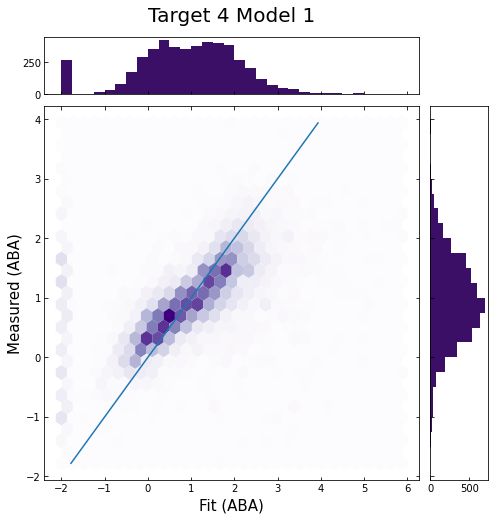

test correlation is 0.5902204143441736


In [96]:
#plug in your favorite model
X,y, energies = create_matrix(big_table1, perfect_sequence1, get_energies=True)
y = vbound(y, MIN=-2, MAX=1000)

reg = linear_model.Ridge(alpha=1)
reg.fit(X, y)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X)
display(vhinge(predicted_output), y, title="Target 4 Model 1")
corr, p_value = pearsonr(vhinge(predicted_output), y)
print("test correlation is",corr)

(array([  3.,   7.,  31.,  92.,  86.,  79., 188., 214., 136.,  25.]),
 array([-28.5       , -26.93000002, -25.36000004, -23.79000006,
        -22.22000008, -20.6500001 , -19.08000011, -17.51000013,
        -15.94000015, -14.37000017, -12.80000019]),
 <BarContainer object of 10 artists>)

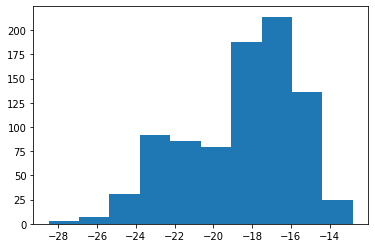

In [97]:
plt.hist([energies[i] for i in range(len(energies)) if y[i] < 0])
#plt.hist([energies[i] for i in range(len(energies))])

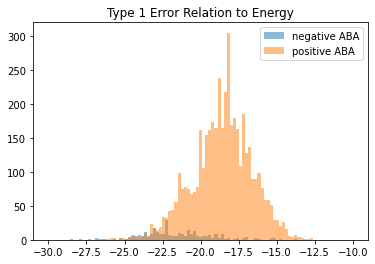

In [98]:
bins = np.linspace(-30, -10, 100)
plt.hist([energies[i] for i in range(len(energies)) if y[i] < -1], bins, alpha=0.5, label='negative ABA')
plt.hist([energies[i] for i in range(len(energies)) if y[i] >= -1], bins, alpha=0.5, label='positive ABA')
plt.legend(loc='upper right')
plt.title("Type 1 Error Relation to Energy")
plt.show()

In [99]:
diffs = np.abs((y-vhinge(predicted_output)))

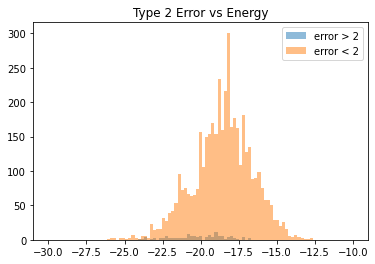

In [101]:
bins = np.linspace(-30, -10, 100)
plt.hist([energies[i] for i in range(len(energies)) if (diffs[i] >2 and y[i] >= -1)], bins, alpha=0.5, label='error > 2')
plt.hist([energies[i] for i in range(len(energies)) if (diffs[i] <=2 and y[i] >= -1)], bins, alpha=0.5, label='error < 2')
plt.legend(loc='upper right')
plt.title("Type 2 Error vs Energy")
plt.show()

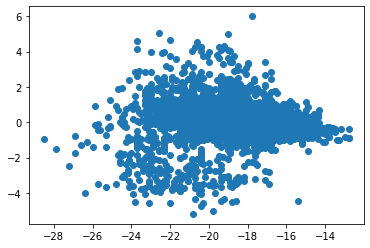

In [47]:
plt.scatter(energies,y-vhinge(predicted_output))

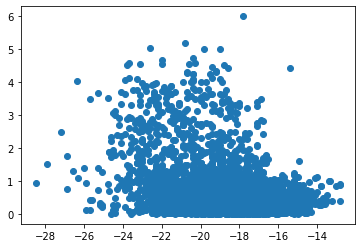

In [49]:
plt.scatter(energies,np.abs(y-vhinge(predicted_output)))

In [37]:
energies

array([-20.60000038, -18.29999924, -18.39999962, ..., -18.29999924,
       -19.20000076, -14.69999981])

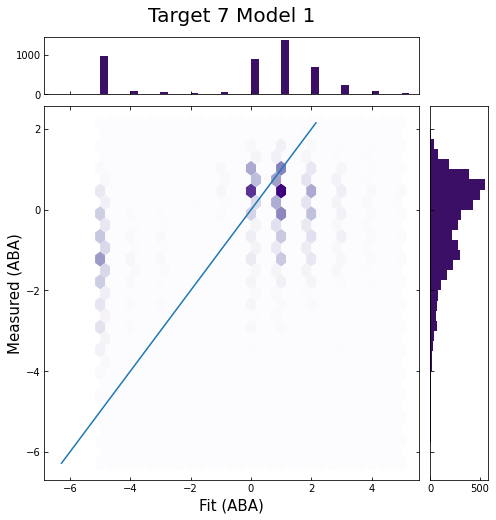

test correlation is 0.4327169430406268


In [79]:
#plug in your favorite model
X,y, energies = create_matrix(big_table2, perfect_sequence2, get_energies=True)
y = vbound(y, MIN=-5, MAX=1000)

reg = linear_model.Ridge(alpha=1)
reg.fit(X, y)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X)
display(vhinge(predicted_output), y, title="Target 7 Model 1")
corr, p_value = pearsonr(vhinge(predicted_output), y)
print("test correlation is",corr)

In [84]:
X.shape

(4460, 198)

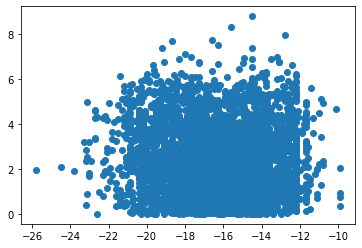

In [41]:
plt.scatter(energies,np.abs(y-vhinge(predicted_output)))

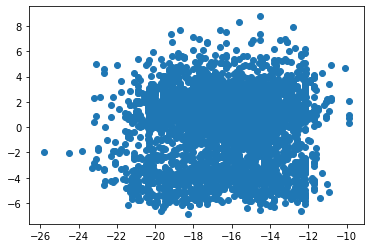

In [42]:
plt.scatter(energies,y-vhinge(predicted_output))